In [15]:
!pip install torch torchvision

In [16]:
!pip install tqdm torchviz

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b0
from tqdm import tqdm
import logging
import torchviz
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch.jit as jit


# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [18]:
# Define the EfficientNet-based feature extractor
class EfficientNetExtractor(nn.Module):
    def __init__(self):
        super(EfficientNetExtractor, self).__init__()
        self.efficient_net = efficientnet_b0(pretrained=True)

        # Remove the last few layers to adapt to smaller input size
        self.feature_extractor = nn.Sequential(
            self.efficient_net.features[0],  # Conv2d
            self.efficient_net.features[1],  # BatchNorm2d
            self.efficient_net.features[2],  # SiLU
            self.efficient_net.features[3],  # MBConv block
            self.efficient_net.features[4],  # MBConv block
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        return x


# Define the Contrastive Clustering Loss
class ContrastiveClusteringLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(ContrastiveClusteringLoss, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, features, labels):
        batch_size = features.shape[0]

        labels = labels.contiguous().view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        contrast_feature = torch.cat([features, features], dim=0)  # Duplicate features for contrastive learning
        anchor_feature = contrast_feature
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)

        # For numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # Mask to remove self-comparisons
        mask = torch.eye(batch_size * 2, device=features.device)
        exp_logits = torch.exp(logits) * (1 - mask)
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # Mean of log-likelihood over positive samples
        loss = -torch.sum(mask * log_prob) / batch_size

        return loss

# Define the adaptive ensemble model with clustering head
class AdaptiveEnsemble(nn.Module):
    def __init__(self, num_classes=10, num_clusters=10):
        super(AdaptiveEnsemble, self).__init__()
        self.feature_extractor1 = EfficientNetExtractor()
        self.feature_extractor2 = EfficientNetExtractor()

        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Adjust the combined_features size based on the output of EfficientNetExtractor
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 32, 32)
            dummy_output = self.feature_extractor1(dummy_input)
            combined_features = dummy_output.shape[1] * 2

        self.fc = nn.Sequential(
            nn.Linear(combined_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
        )

        self.clustering_head = nn.Linear(combined_features, num_clusters)

    def forward(self, x):
        features1 = self.feature_extractor1(x)
        features2 = self.feature_extractor2(x)

        # Apply adaptive pooling
        features1 = self.adaptive_pool(features1).flatten(1)
        features2 = self.adaptive_pool(features2).flatten(1)

        # Combine features from both feature extractors
        combined_features = torch.cat([features1, features2], dim=1)
        classification_output = self.fc(combined_features)
        clustering_output = self.clustering_head(combined_features)

        return classification_output, clustering_output

In [30]:
batch_size = 64
dataloader_workers = 2
train_val_split_factor = 0.8 # 80%
nc = 10
_lr = 0.001
train_epochs = 10
# pretrain_epochs = 10


# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AdaptiveEnsemble(num_classes=nc, num_clusters=nc).to(device)
classification_criterion = nn.CrossEntropyLoss()
contrastive_criterion = ContrastiveClusteringLoss()
optimizer = optim.Adam(model.parameters(), lr=_lr)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
# Data loading and augmentation
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter()], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [27]:
# Load the full training set
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# Split the full training set into train and validation sets
train_size = int(train_val_split_factor * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

Files already downloaded and verified


In [25]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=dataloader_workers)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=dataloader_workers)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=dataloader_workers)

Files already downloaded and verified


In [31]:
# # Training and testing functions
# def pretrain(model, dataloader, contrastive_criterion, optimizer, device):
#     model.train()
#     running_loss = 0.0
#     progress_bar = tqdm(dataloader, desc="Pretraining", leave=False)
#     for inputs, labels in progress_bar:
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()

#         _, clustering_output = model(inputs)
#         loss = contrastive_criterion(clustering_output, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item() * inputs.size(0)
#         progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

#     return running_loss / len(dataloader.dataset)

def train(model, dataloader, classification_criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs, _ = model(inputs)
        loss = classification_criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

    return running_loss / len(dataloader.dataset)

def evaluate(model, dataloader, classification_criterion, device):
    model.eval()
    correct = 0
    total = 0
    eval_loss = 0.0

    progress_bar = tqdm(dataloader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)
            loss = classification_criterion(outputs, labels)
            eval_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

    accuracy = 100 * correct / total
    return eval_loss / len(dataloader.dataset), accuracy


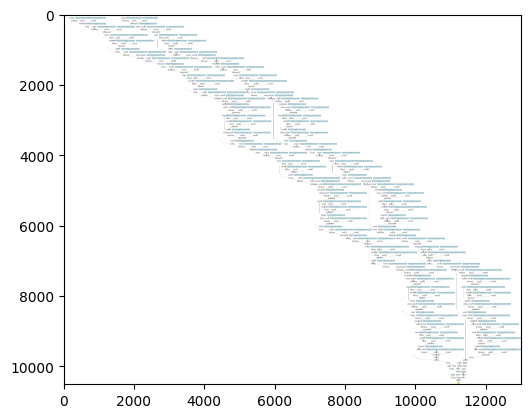

In [34]:
# Generate model diagram
def generate_model_diagram(model):
    x = torch.randn(1, 3, 32, 32).to(device)  # Use 32x32 input size
    try:
        y = model(x)
        dot = torchviz.make_dot(y[0], params=dict(model.named_parameters()))
        dot.render("model_diagram", format="png")
        logging.info("Model diagram generated and saved as 'model_diagram.png'")
    except Exception as e:
        logging.error(f"Failed to generate model diagram: {str(e)}")

# Generate the model diagram
generate_model_diagram(model)
img = mpimg.imread('model_diagram.png')

plt.imshow(img)
plt.show()

In [ ]:
# Pretraining the model with contrastive loss
# for epoch in range(pretrain_epochs):
#     pretrain_loss = pretrain(model, trainloader, contrastive_criterion, optimizer, device)
#     logging.info(f'Pretrain Epoch {epoch+1}/{pretrain_epochs}, Pretrain Loss: {pretrain_loss:.4f}')

# Fine-tuning the model with classification loss
best_val_accuracy = 0
for epoch in range(train_epochs):
    logging.info(f"epoch: {epoch}")
    train_loss = train(model, trainloader, classification_criterion, optimizer, device)
    val_loss, val_accuracy = evaluate(model, valloader, classification_criterion, device)

    logging.info(f'Finetune Epoch {epoch+1}/{train_epochs}, '
                 f'Train Loss: {train_loss:.4f}, '
                 f'Val Loss: {val_loss:.4f}, '
                 f'Val Accuracy: {val_accuracy:.2f}%')

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        logging.info(f'New best model saved with validation accuracy: {best_val_accuracy:.2f}%')

# Load the best model and evaluate on the test set
model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_accuracy = evaluate(model, testloader, classification_criterion, device)
logging.info(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Training:   1%|▏         | 8/625 [00:05<06:33,  1.57it/s, Loss=1.1233]

In [ ]:
scripted_model = torch.jit.script(model)
torch.jit.save(scripted_model, 'jit_model.pt')

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt


testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AdaptiveEnsemble(num_classes=nc, num_clusters=nc).to(device)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(testloader)
images, labels = next(dataiter)

logging.info(f"""Ground Truth: {' '.join(f'{classes[labels[j]]:5s}' for j in range(4))}""")

imshow(torchviz.utils.make_grid(images[:4]))

outputs = model(images.to(device))[0]
_, predicted = torch.max(outputs, 1)

logging.info(f"""Predicted: ', {' '.join(f'{classes[predicted[j]]:5s}' for j in range(4))}""")

def get_prediction(image):
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))[0]
        _, predicted = torch.max(output, 1)
        return classes[predicted.item()]

num_samples = 10
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Sample Predictions", fontsize=16)

for i in range(num_samples):
    ax = axes[i // 5, i % 5]
    image, label = testset[i]
    prediction = get_prediction(image)

    imshow(image)
    ax.set_title(f"True: {classes[label]}\nPred: {prediction}")
    ax.axis('off')

plt.tight_layout()
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)[0]
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

logging.info(f'Accuracy on the test set: {100 * correct / total:.2f}%')